In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os.path
import os
from datetime import datetime
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.models import load_model
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  3


In [2]:
os.getcwd()

'/workspace/IFA_DIR/TMA'

In [3]:
date_parser = lambda x: datetime.strptime(x, '%y%m%d%H%M%S')
df = pd.read_csv("data/karang.csv", parse_dates = ['date'], date_parser = date_parser, sep=';')
df.head()

,date,code,no_machine,prov,kab,kec,lokasi,precip,soil_moisture,gwl,temp,lat,long
0,2018-11-09 08:00:00,BRG_160611_01,286827114,SUMATERA SELATAN,MUSI BANYUASIN,LALAN,Karang agung,0,"27,8","-2,2","26,9","-2,28165300","104,41130000"
1,2018-11-09 08:10:00,BRG_160611_01,286827114,SUMATERA SELATAN,MUSI BANYUASIN,LALAN,Karang agung,0,"28,3",-2154,"27,5","-2,28165300","104,41130000"
2,2018-11-09 08:20:00,BRG_160611_01,286827114,SUMATERA SELATAN,MUSI BANYUASIN,LALAN,Karang agung,"0,2","29,2",-2142,"27,8","-2,28165300","104,41130000"
3,2018-11-09 08:30:00,BRG_160611_01,286827114,SUMATERA SELATAN,MUSI BANYUASIN,LALAN,Karang agung,0,"29,2",-2125,28,"-2,28165300","104,41130000"
4,2018-11-09 08:40:00,BRG_160611_01,286827114,SUMATERA SELATAN,MUSI BANYUASIN,LALAN,Karang agung,0,"29,3","-2,12",28,"-2,28165300","104,41130000"


In [4]:
df.dtypes

date             datetime64[ns]
code                     object
no_machine                int64
prov                     object
kab                      object
kec                      object
lokasi                   object
precip                   object
soil_moisture            object
gwl                      object
temp                     object
lat                      object
long                     object
dtype: object

In [5]:
df = df.drop(['no_machine', 'prov', 'kab', 'kec', 'lat', 'long'], 1)

In [6]:
df['code'].unique()

array(['BRG_160611_01'], dtype=object)

In [7]:
df['lokasi'].unique()

array(['Karang agung'], dtype=object)

In [8]:
df['precip'] = df['precip'].str.replace(",", ".")
df['soil_moisture'] = df['soil_moisture'].str.replace(",", ".")
df['gwl'] = df['gwl'].str.replace(",", ".")
df['temp'] = df['temp'].str.replace(",", ".")

In [9]:
df['precip'] = df['precip'].astype(float)
df['soil_moisture'] = df['soil_moisture'].astype(float)
df['gwl'] = df['gwl'].astype(float)
df['temp'] = df['temp'].astype(float)

In [10]:
df_kedaton_demplot = df[df['lokasi'] == 'Kedaton (Demplot)']
df_kedaton= df[df['lokasi'] == 'Kedaton']
df_padang_sugihan_1 = df[df['lokasi'] == 'Padang Sugihan 1 (SM)']
df_padang_sugihan_2 = df[df['lokasi'] == 'Padang Sugihan 2 (SM)']
df_padang_sugihan_3 = df[df['lokasi'] == 'Padang Sugihan 3 (SM)']
df_air_rumbai = df[df['lokasi'] == 'Air Rumbai']
df_cinta_jaya_1 = df[df['lokasi'] == 'Cinta Jaya 1']
df_cinta_jaya_2 = df[df['lokasi'] == 'Cinta Jaya 2']
df_cinta_jaya_3 = df[df['lokasi'] == 'Cinta Jaya 3']
df_muara_medak_1 = df[df['lokasi'] == 'Muara Medak 1']
df_muara_medak_2 = df[df['lokasi'] == 'Muara Medak 2']
df_karang_agung = df[df['lokasi'] == 'Karang agung']

In [11]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [12]:
def min_max(variable):
  res = (variable - variable.min())/(variable.max() - variable.min())
  return res

In [13]:
date_parser = lambda x: datetime.strptime(x, '%y%m%d%H%M%S')
df = pd.read_csv("data/karang.csv", parse_dates = ['date'], date_parser = date_parser, sep=';')
df.head()

,date,code,no_machine,prov,kab,kec,lokasi,precip,soil_moisture,gwl,temp,lat,long
0,2018-11-09 08:00:00,BRG_160611_01,286827114,SUMATERA SELATAN,MUSI BANYUASIN,LALAN,Karang agung,0,"27,8","-2,2","26,9","-2,28165300","104,41130000"
1,2018-11-09 08:10:00,BRG_160611_01,286827114,SUMATERA SELATAN,MUSI BANYUASIN,LALAN,Karang agung,0,"28,3",-2154,"27,5","-2,28165300","104,41130000"
2,2018-11-09 08:20:00,BRG_160611_01,286827114,SUMATERA SELATAN,MUSI BANYUASIN,LALAN,Karang agung,"0,2","29,2",-2142,"27,8","-2,28165300","104,41130000"
3,2018-11-09 08:30:00,BRG_160611_01,286827114,SUMATERA SELATAN,MUSI BANYUASIN,LALAN,Karang agung,0,"29,2",-2125,28,"-2,28165300","104,41130000"
4,2018-11-09 08:40:00,BRG_160611_01,286827114,SUMATERA SELATAN,MUSI BANYUASIN,LALAN,Karang agung,0,"29,3","-2,12",28,"-2,28165300","104,41130000"


In [14]:
df.drop(['lat', 'long'], 1, inplace = True)
df.drop_duplicates(subset = ['date', 'code', 'no_machine', 'prov', 'kab', 'kec', 'lokasi', 'precip', 'soil_moisture', 'gwl', 'temp'], keep = 'first', inplace = True)
df.drop(['code', 'no_machine', 'prov', 'kab', 'kec', 'lokasi'], 1, inplace = True)
df = df[['date', 'precip', 'soil_moisture', 'temp', 'gwl']]

In [15]:
df['precip'] = df['precip'].str.replace(",", ".")
df['soil_moisture'] = df['soil_moisture'].str.replace(",", ".")
df['gwl'] = df['gwl'].str.replace(",", ".")
df['temp'] = df['temp'].str.replace(",", ".")

In [16]:
df['precip'] = df['precip'].astype(float)
df['soil_moisture'] = df['soil_moisture'].astype(float)
df['gwl'] = df['gwl'].astype(float)
df['temp'] = df['temp'].astype(float)

In [17]:
df = df.groupby('date').agg({
    'precip': 'mean',
    'soil_moisture': 'mean',
    'gwl': 'mean',
    'temp': 'mean'
})

In [18]:
df.head()

,precip,soil_moisture,gwl,temp
date,,,,
2018-11-09 08:00:00,0.0,27.8,-2.20,26.9
2018-11-09 08:10:00,0.0,28.3,-2154.00,27.5
2018-11-09 08:20:00,0.2,29.2,-2142.00,27.8
2018-11-09 08:30:00,0.0,29.2,-2125.00,28.0
2018-11-09 08:40:00,0.0,29.3,-2.12,28.0


array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

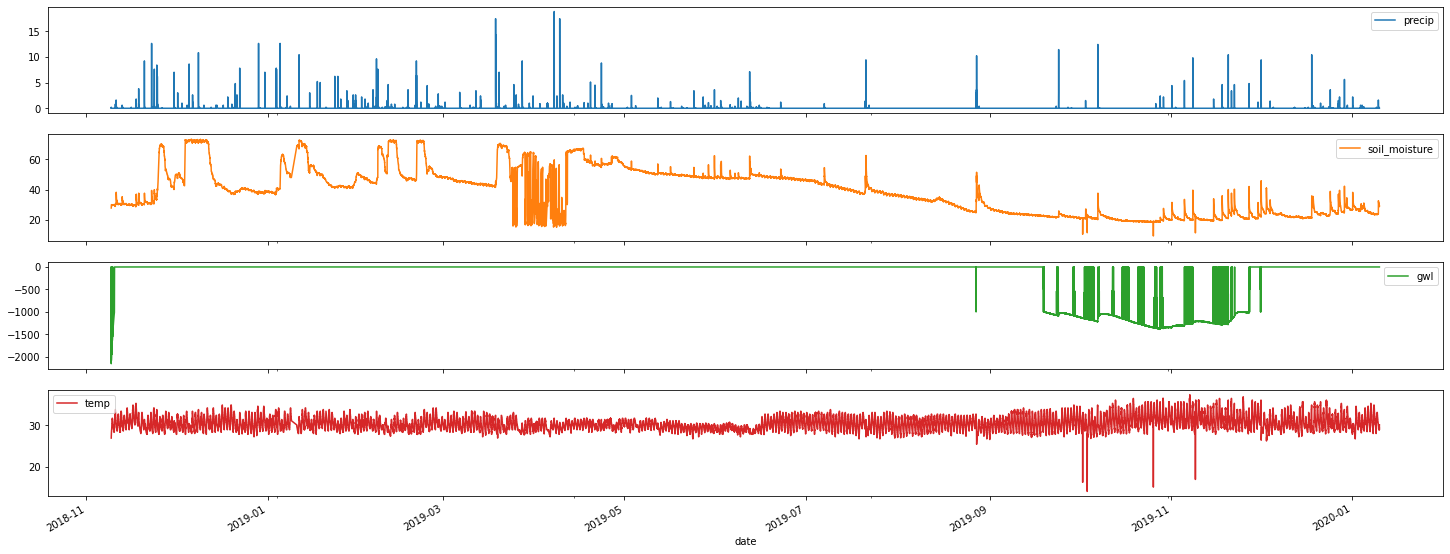

In [19]:
df.plot(subplots=True, figsize=(25,10))

In [20]:
df.loc[df['gwl'] <= -2.0, 'gwl'] = np.nan
df.loc[df['soil_moisture'] <= 5, 'soil_moisture'] = np.nan
df.loc[df['temp'] <= 20, 'temp'] = np.nan

In [21]:
df.isna().sum()

precip              0
soil_moisture       0
gwl              9884
temp                4
dtype: int64

In [22]:
df['gwl'].fillna(value = df['gwl'].mean(), inplace=True)
df['soil_moisture'].fillna(value = df['soil_moisture'].mean(), inplace=True)
df['temp'].fillna(value = df['temp'].mean(), inplace=True)

In [23]:
daterange_total = pd.date_range(start=df.index.min(), 
                                end=df.index.max(), 
                                freq="10T")
daterange_total.difference(df.index)

DatetimeIndex(['2018-11-14 08:30:00', '2018-11-14 08:40:00',
               '2018-11-14 08:50:00', '2018-11-14 09:00:00',
               '2018-11-14 09:10:00', '2018-11-15 20:10:00',
               '2018-11-15 20:20:00', '2018-11-15 20:30:00',
               '2018-11-18 10:20:00', '2018-11-18 10:30:00',
               ...
               '2019-10-08 08:30:00', '2019-10-09 02:50:00',
               '2019-10-21 15:30:00', '2019-11-22 22:50:00',
               '2019-12-04 11:40:00', '2019-12-12 08:40:00',
               '2019-12-12 09:10:00', '2019-12-12 09:40:00',
               '2020-01-06 06:10:00', '2020-01-06 16:20:00'],
              dtype='datetime64[ns]', length=1325, freq=None)

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

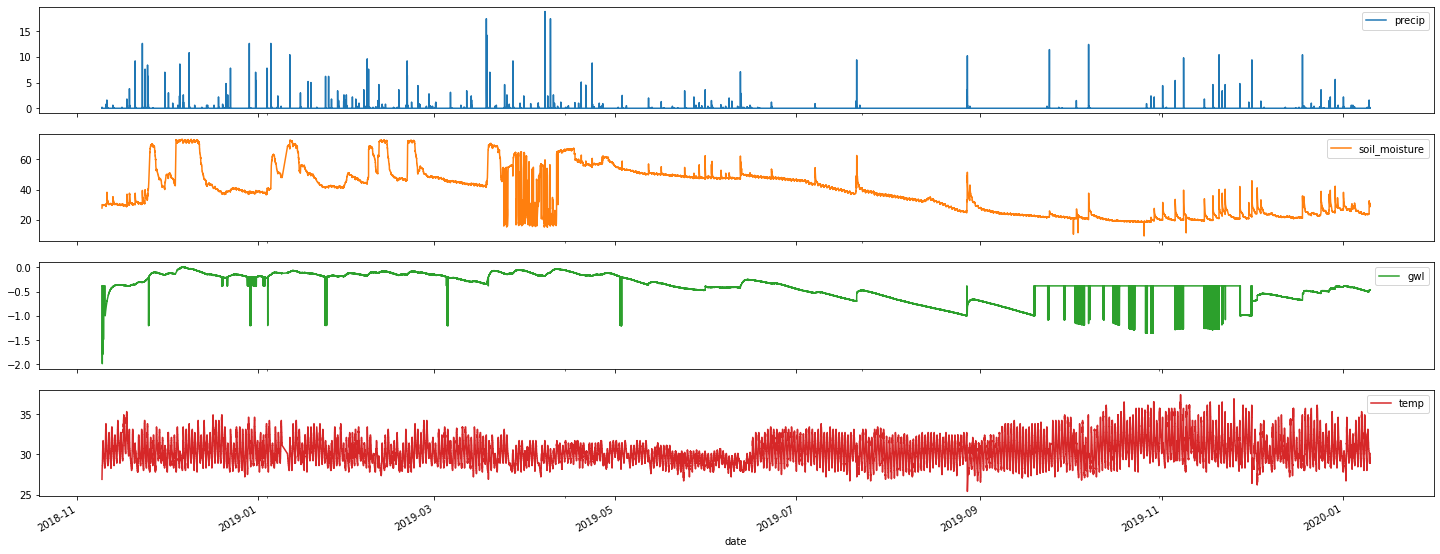

In [24]:
df.plot(subplots=True, figsize=(25,10))

In [25]:
min_gwl_df = df['gwl'].min()
max_gwl_df = df['gwl'].max()

df['precip'] = min_max(df['precip'])
df['soil_moisture'] = min_max(df['soil_moisture'])
df['temp'] = min_max(df['temp'])
df['gwl'] = min_max(df['gwl'])
df = df.reindex(columns=['gwl', 'precip', 'soil_moisture', 'temp'])
scaled_df = df.values

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

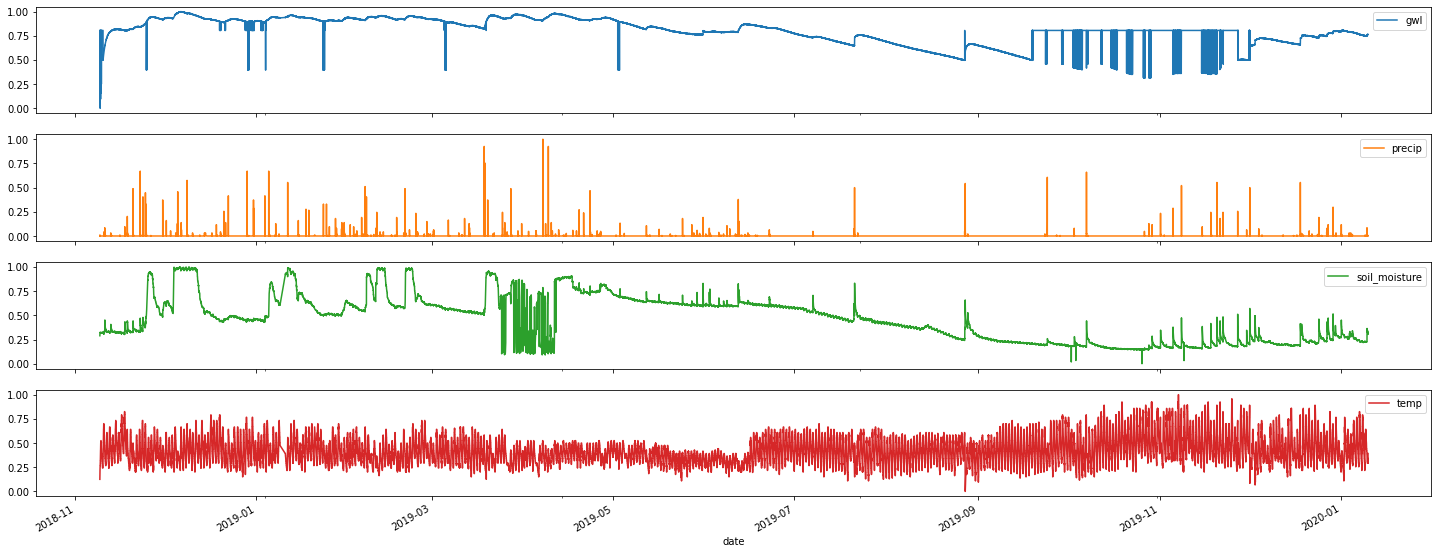

In [26]:
df.plot(subplots=True, figsize=(25,10))

In [32]:
timestep = 144
n_features = 4

In [33]:
reframed_df = series_to_supervised(scaled_df, timestep, 1)
reframed_df = reframed_df.iloc[:, :-3]
print(reframed_df.head())

     var1(t-144)  var2(t-144)  var3(t-144)  var4(t-144)  var1(t-143)  \
144     0.000000     0.002275      0.03355     0.533333     0.001183   
145     0.001183     0.000000      0.03355     0.533333     0.005325   
146     0.005325     0.000000      0.03355     0.533333     0.005325   
147     0.005325     0.000000      0.03355     0.586667     0.010059   
148     0.010059     0.000000      0.03355     0.586667     0.011243   

     var2(t-143)  var3(t-143)  var4(t-143)  var1(t-142)  var2(t-142)  ...  \
144          0.0      0.03355     0.533333     0.005325          0.0  ...   
145          0.0      0.03355     0.533333     0.005325          0.0  ...   
146          0.0      0.03355     0.586667     0.010059          0.0  ...   
147          0.0      0.03355     0.586667     0.011243          0.0  ...   
148          0.0      0.03355     0.586667     0.011243          0.0  ...   

     var4(t-3)  var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var1(t-1)  \
144   0.253333   0.401775      

In [34]:
new_df = pd.DataFrame(reframed_df)
y = new_df.iloc[:, -1:]
x = new_df.iloc[:, :-1]

In [ ]:
model = XGBRegressor()
model.fit(x, y)

In [ ]:
thresholds = np.sort(model.feature_importances_)
selection = SelectFromModel(model, threshold=0, prefit=True)

In [ ]:
feature_idx = selection.get_support()
selected_dataset = selection.transform(x)
print(selected_dataset.shape)

In [ ]:
train_ind_df = int(len(reframed_df)*0.8)

reframed_df = x.values
train_df = reframed_df[:train_ind_df, :]
test_df = reframed_df[train_ind_df:, :]

n_obs = timestep * n_features
train_X, train_y = train_df[:, :n_obs], train_df[:, -1]
test_X, test_y = test_df[:, :n_obs], test_df[:, -1]

In [ ]:
train_X = train_X.reshape((train_X.shape[0], timestep, n_features))
test_X = test_X.reshape((test_X.shape[0], timestep, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
#epoch = [25, 50]
#unit_1 = [10, 30, 50]
#dropout_1 = [0.2, 0.4, 0.6]
#unit_2 = [10, 30, 50]
#dropout_2 = [0.2, 0.4, 0.6]
#dense = [100, 300, 500]
epoch = [25, 50]
unit_1 = [10]
dropout_1 = [0.2]
unit_2 = [10]
dropout_2 = [0.2]
dense = [100]
result = pd.DataFrame(columns=["model_name",
                               "rmse",
                               "rsquare",
                               "mae"])

In [ ]:
for a in epoch:
    for b in unit_1:
        for c in dropout_1:
            for d in dense:
                for e in unit_2:
                    for f in dropout_2:
                        model = Sequential()
                        model.add(LSTM(b, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
                        model.add(Dropout(c))
                        model.add(Dense(d, activation='relu'))
                        model.add(LSTM(e, return_sequences=False))
                        model.add(Dropout(f))
                        model.add(Dense(1))
                        model.compile(optimizer='adam', loss='mean_squared_error',
                                      metrics=['mse', 'mae', 'mape'])
                        model.fit(train_X, train_y, epochs=a, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
                        model_name = "SAVE_MODEL/" + "model_" + str(a) + "_" + str(b) + "_" + str(c) + "_" + str(d) + "_" + str(e) + "_" + str(f) + ".h5"
                        model.save("%s" % str(model_name))
                        
                        ypred = model.predict(test_X)
                        inv_ypred = ypred.flatten()*(max_gwl_df - min_gwl_df) + min_gwl_df
                        
                        inv_yact = test_y*(max_gwl_df - min_gwl_df) + min_gwl_df
                        
                        rmse = sqrt(mean_squared_error(inv_yact, inv_ypred))
                        rsquare = r2_score(inv_yact, inv_ypred)
                        mae = mean_absolute_error(inv_yact, inv_ypred)
                        
                        df= pd.DataFrame({"model_name": str(model_name),
                                          "rmse": rmse,
                                          "rsquare": rsquare,
                                          "mae": mae}, index=[0])
                        
                        result = result.append(df, ignore_index=True)
                                
                        tf.keras.backend.clear_session()

In [ ]:
print(result)

In [ ]:
model = load_model("SAVE_MODEL/model_50_10_0.2_100_10_0.2.h5")

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
ypred = model.predict(test_X)
inv_ypred = ypred.flatten()*(max_gwl_df - min_gwl_df) + min_gwl_df

In [ ]:
inv_yact = test_y*(max_gwl_df - min_gwl_df) + min_gwl_df

In [ ]:
rmse = sqrt(mean_squared_error(inv_yact, inv_ypred))
rsquare = r2_score(inv_yact, inv_ypred)
mae = mean_absolute_error(inv_yact, inv_ypred)
print('Test RMSE: %.5f' % rmse)
print('Test R-Squared: %.5f' % rsquare)
print('Test MAE: %.5f' % mae)

In [ ]:
len(df.index[train_ind_df:])

In [ ]:
df_result = pd.DataFrame({
    'date': df.index[train_ind_df+144:],
    'actual': inv_yact,
    'predicted': inv_ypred
})

In [ ]:
plt.figure(figsize=(19, 7))
plt.plot(df_result['date'], df_result['predicted'], 'b-', label = 'PRED')
plt.plot(df_result['date'], df_result['actual'], 'r-', label = 'ACT')
plt.xlabel('Date')
plt.ylabel('GWL')
plt.title('GRAFIK GWL DATA TEST')
plt.legend();

In [ ]:
def plot_pred(test_X, model, model_name):
  ypred = model.predict(test_X)
  inv_ypred = ypred.flatten()*(max_gwl_df - min_gwl_df) + min_gwl_df
  
  inv_yact = test_y*(max_gwl_df - min_gwl_df) + min_gwl_df

  len(df.index[train_ind_df:])

  df_result = pd.DataFrame({
      'date': df.index[train_ind_df+144:],
      'actual': inv_yact,
      'predicted': inv_ypred
      })
  
  plt.figure(figsize=(19, 7))
  plt.plot(df_result['date'], df_result['predicted'], 'b-', label = 'PRED')
  plt.plot(df_result['date'], df_result['actual'], 'r-', label = 'ACT')
  plt.legend()
  plt.xlabel('Date')
  plt.ylabel('GWL')
  plt.title('GRAFIK GWL DATA TEST')
  plt_predname = "plot/predict/" + str(model_name) + ".png"
  print(plt_predname)
  plt.savefig("%s" % str(plt_predname))

  plt.close()
